In [1]:
import numpy as np
import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F

from livelossplot import PlotLosses
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [3]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-
#glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Set script-wide constants

In [6]:
FOLDER_TEST = './datasets/test/'
FOLDER = './datasets/train/'

CLASSES = ['n', 's', 'e', 'w', 'cw', 'aw', 't']

WINDOW = 5
ELECTRODES = 24
VAL_SPLIT = 0.20

## Read train dataset and split it in train - validation

In [7]:
dataset = np.zeros((0, WINDOW, ELECTRODES))
labels = np.zeros((0))
    
print(dataset.shape)
print(labels.shape)

for class_name in CLASSES:
    file = FOLDER + class_name + '-' + str(WINDOW) + '-ff'
    
    print(file)
    
    class_data = np.load(file + '-data.npy')
    class_labels = np.load(file + '-labels.npy')
    
    print(class_data.shape)
    print(class_labels.shape)
    
    dataset = np.append(dataset, class_data, axis=0)
    labels = np.append(labels, np.reshape(class_labels, (class_labels.shape[0])), axis=0)
    
    print(dataset.shape)
    print(labels.shape)

# Normalize data! Really necessary in this dataset
x_min = dataset.min(axis=(2), keepdims=True)
x_max = dataset.max(axis=(2), keepdims=True)

dataset = (dataset - x_min)/(x_max - x_min)
    
data_train, data_val, labels_train, labels_val = train_test_split(dataset, labels, test_size=VAL_SPLIT,
                                                                    random_state=42)

print('Dataset split')
print(data_train.shape)
print(data_val.shape)
print(labels_train.shape)
print(labels_val.shape)

(0, 5, 24)
(0,)
./datasets/train/n-5-ff
(880, 5, 24)
(880, 1)
(880, 5, 24)
(880,)
./datasets/train/s-5-ff
(888, 5, 24)
(888, 1)
(1768, 5, 24)
(1768,)
./datasets/train/e-5-ff
(885, 5, 24)
(885, 1)
(2653, 5, 24)
(2653,)
./datasets/train/w-5-ff
(828, 5, 24)
(828, 1)
(3481, 5, 24)
(3481,)
./datasets/train/cw-5-ff
(885, 5, 24)
(885, 1)
(4366, 5, 24)
(4366,)
./datasets/train/aw-5-ff
(883, 5, 24)
(883, 1)
(5249, 5, 24)
(5249,)
./datasets/train/t-5-ff
(883, 5, 24)
(883, 1)
(6132, 5, 24)
(6132,)
Dataset split
(4905, 5, 24)
(1227, 5, 24)
(4905,)
(1227,)


(array([0.16340469, 0.16602107, 0.16792389, 0.1643561 , 0.17101597,
        0.16578321, 0.16816174]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

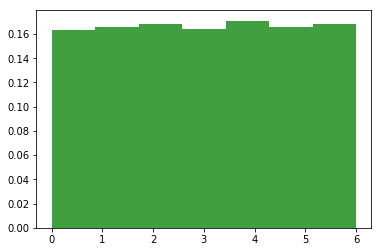

In [8]:
plt.hist(labels_train, bins=len(CLASSES), density=True, facecolor='g', alpha=0.75)

In [9]:
# Changed for using GPU
data_val = torch.from_numpy(data_val)
data_val = data_val.to(device, dtype=torch.float)

labels_val = torch.from_numpy(labels_val)
labels_val = labels_val.to(device, dtype=torch.long)

## Define LSTM and train

In [10]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc1_bn = nn.BatchNorm1d(hidden_size)
        self.fc1_drop = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        #out = F.relu(self.fc1_bn(self.fc1(out[:, -1, :])))
        out = F.relu(self.fc1(out[:, -1, :]))
        out = self.fc1_drop(out)
        out = self.fc2(out)
        
        return out

In [11]:
input_size = ELECTRODES
hidden_size = 32
num_layers = 3
num_classes = len(CLASSES)
dropout = 0.3

model = RNN(input_size, hidden_size, num_layers, num_classes, dropout=dropout).to(device)

# Loss and optimizer
learning_rate = 0.001
l2_reg = 0.001
step_size = 60
lr_decay = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=lr_decay)

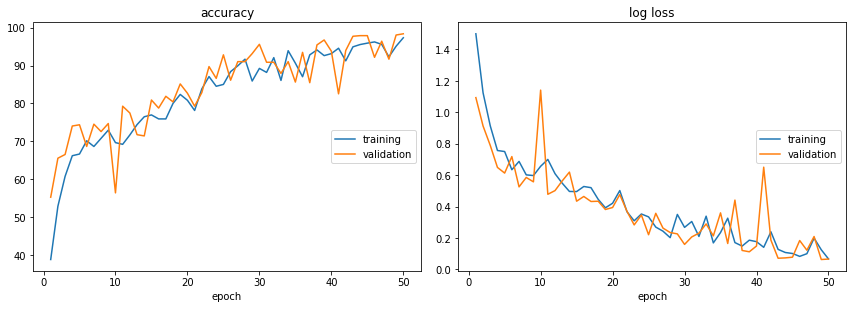

In [10]:
epochs = 25
batch = 32
loss_history = []
loss_history_val = []
acc_history = []
acc_history_val = []

steps = math.ceil(data_train.shape[0] / batch)
print('Epochs:', epochs, 'Batch:', batch, 'Steps:', steps)

liveloss = PlotLosses()

for epoch in range(epochs):  # loop over the dataset multiple times
    print('===== epoch', epoch + 1, '=====')
        
    scheduler.step()
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    epoch_correct = 0
    
    for param_group in optimizer.param_groups:
        print('>> lr:', param_group['lr'])
        
    # Shuffle dataset so epochs receive data in batches with different order
    data_train, labels_train = shuffle(data_train, labels_train)
    
    for i in range(steps):
        # get the inputs
        #batch, time, channels, height, width
        batch_data = torch.from_numpy(data_train[batch * i : batch * i + batch])
        batch_labels = torch.from_numpy(labels_train[batch * i : batch * i + batch])
        
        #print(batch_data.shape, batch_labels.shape)
        
        # Changed for using GPU
        batch_data = batch_data.to(device, dtype=torch.float)
        batch_labels = batch_labels.to(device, dtype=torch.long)
        
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        
        epoch_loss += loss.data[0]  
        epoch_correct += (outputs.max(1)[1] == batch_labels).sum().data[0]
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}'.format(epoch + 1, epochs, i + 1, steps, loss.item()))
            
    loss_history.append(epoch_loss / steps)
    acc_history.append(epoch_correct.item() / (steps * batch) * 100)
    
    with torch.no_grad(): # We don't want to track gradients now because we are not training the network.
        outputs_val = model(data_val)
        loss = criterion(outputs_val, labels_val)

        epoch_loss_val = loss.data[0]

        _, predicted_val = torch.max(outputs_val.data, 1)
        total = labels_val.size(0)
        epoch_correct_val = (predicted_val == labels_val).sum().item()

    loss_history_val.append(epoch_loss_val)
    acc_history_val.append((epoch_correct_val / total) * 100)

    liveloss.update({
        'log loss': loss_history[-1],
        'val_log loss': loss_history_val[-1],
        'accuracy': acc_history[-1],
        'val_accuracy': acc_history_val[-1]
    })
    liveloss.draw()

In [11]:
with torch.no_grad(): # We don't want to track gradients now because we are not training the network.
    outputs_val = model(data_val)

_, predicted_val = torch.max(outputs_val.data, 1)

total = labels_val.size(0)
correct = (predicted_val == labels_val).sum().item()
score = correct / total

[precision, recall, f1_score, _] = precision_recall_fscore_support(labels_val, predicted_val, average=None,
                                                                   pos_label=1)
    
print("accuracy:", score * 100)
print("precision:", precision * 100)
print("recall:", recall * 100)
print("f1_score:", f1_score * 100)

accuracy: 98.36867862969005
precision: [ 99.03846154 100.         100.         100.          94.80519481
  95.69892473  98.66666667]
recall: [100.         100.         100.         100.          98.64864865
  95.69892473  93.67088608]
f1_score: [ 99.51690821 100.         100.         100.          96.68874172
  95.69892473  96.1038961 ]


Confusion matrix, without normalization


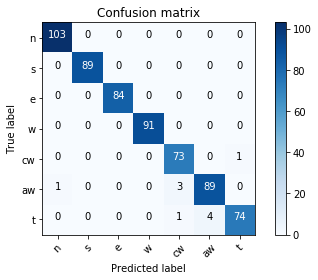

In [12]:
cnf_matrix = confusion_matrix(labels_val, predicted_val)

plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=CLASSES, title='Confusion matrix')

## Read test dataset

In [13]:
dataset_test = np.zeros((0, WINDOW, ELECTRODES))
labels_test = np.zeros((0))
    
print(dataset_test.shape)
print(labels_test.shape)

for class_name in CLASSES:
    file = FOLDER_TEST + class_name + '-' + str(WINDOW) + '-ff'
    
    print(file)
    
    class_data = np.load(file + '-data.npy')
    class_labels = np.load(file + '-labels.npy')
    
    print(class_data.shape)
    print(class_labels.shape)
    
    dataset_test = np.append(dataset_test, class_data, axis=0)
    labels_test = np.append(labels_test, np.reshape(class_labels, (class_labels.shape[0])), axis=0)
    
    print(dataset_test.shape)
    print(labels_test.shape)

# Normalize data! Really necessary in this dataset
x_min = dataset_test.min(axis=(2), keepdims=True)
x_max = dataset_test.max(axis=(2), keepdims=True)

dataset_test = (dataset_test - x_min)/(x_max - x_min)

(0, 10, 24)
(0,)
./datasets/test/n-10-ff
(221, 10, 24)
(221, 1)
(221, 10, 24)
(221,)
./datasets/test/s-10-ff
(220, 10, 24)
(220, 1)
(441, 10, 24)
(441,)
./datasets/test/e-10-ff
(222, 10, 24)
(222, 1)
(663, 10, 24)
(663,)
./datasets/test/w-10-ff
(220, 10, 24)
(220, 1)
(883, 10, 24)
(883,)
./datasets/test/cw-10-ff
(221, 10, 24)
(221, 1)
(1104, 10, 24)
(1104,)
./datasets/test/aw-10-ff
(222, 10, 24)
(222, 1)
(1326, 10, 24)
(1326,)
./datasets/test/t-10-ff
(220, 10, 24)
(220, 1)
(1546, 10, 24)
(1546,)


(array([0.16677447, 0.16601984, 0.16752911, 0.16601984, 0.16677447,
        0.16752911, 0.16601984]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

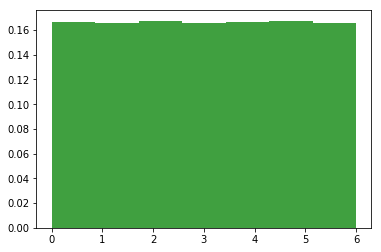

In [14]:
plt.hist(labels_test, bins=len(CLASSES), density=True, facecolor='g', alpha=0.75)

In [15]:
# Changed for using GPU
dataset_test = torch.from_numpy(dataset_test)
dataset_test = dataset_test.to(device, dtype=torch.float)

labels_test = torch.from_numpy(labels_test)
labels_test = labels_test.to(device, dtype=torch.long)

## Check model performance on test set

In [16]:
with torch.no_grad(): # We don't want to track gradients now because we are not training the network.
    outputs_test = model(dataset_test)

_, predicted_test = torch.max(outputs_test.data, 1)

total_test = labels_test.size(0)
correct_test = (predicted_test == labels_test).sum().item()
score_test = correct_test / total_test

[precision_test, recall_test, f1_score_test, _] = precision_recall_fscore_support(labels_test, predicted_test,
                                                                                  average=None, pos_label=1)
    
print("accuracy:", score_test * 100)
print("precision:", precision_test * 100)
print("recall:", recall_test * 100)
print("f1_score:", f1_score_test * 100)

accuracy: 74.83829236739975
precision: [100.          88.66396761  97.36842105 100.          37.72893773
  48.77192982  45.83333333]
recall: [100.          99.54545455 100.         100.          46.60633484
  62.61261261  15.        ]
f1_score: [100.          93.79014989  98.66666667 100.          41.70040486
  54.83234714  22.60273973]


Confusion matrix, without normalization


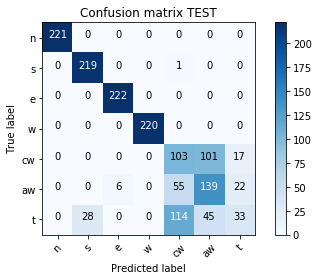

In [17]:
cnf_matrix_test = confusion_matrix(labels_test, predicted_test)

plt.figure()
plot_confusion_matrix(cnf_matrix_test, normalize=False, classes=CLASSES, title='Confusion matrix TEST')